# 1時間分の気温データから電力消費量を推測

In [1]:
# coding: utf-8
import pandas as pd
import sklearn.svm
import sklearn.model_selection


# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    'shikoku_electricity_%d.csv' % year,
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col='date_hour')
    for year in [2012, 2013, 2014, 2015, 2016]
]

elec_data = pd.concat(ed)

# 気象データを読み込み
tmp = pd.read_csv(
    u'47891_takamatsu.csv',
    parse_dates={'date_hour': ["日時"]},
    index_col="date_hour",
    na_values="×"
)

del tmp["時"]  # 「時」の列は使わないので、削除

# 列の名前に日本語が入っているとよくないので、これから使う列の名前のみ英語に変更
columns = {
    "降水量(mm)": "rain",
    "気温(℃)": "temperature",
    "日照時間(h)": "sunhour",
    "湿度(％)": "humid",
}
tmp.rename(columns=columns, inplace=True)

# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
takamatsu = elec_data.join(tmp["temperature"]).dropna().as_matrix()

takamatsu_elec = takamatsu[:, 0:1]
takamatsu_wthr = takamatsu[:, 1:]

# 交差検定の準備
kf = sklearn.model_selection.KFold(n_splits=5)

# 交差検定実施(全てのパターンを実施)
for train, test in kf.split(takamatsu_elec):
    x_train = takamatsu_wthr[train]
    x_test = takamatsu_wthr[test]
    y_train = takamatsu_elec[train]
    y_test = takamatsu_elec[test]

    # -- SVR --
    model = sklearn.svm.SVR()
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    model.fit(x_train, y_train)
    print("SVR: Training Score = %f, Testing(Validate) Score = %f" %
          (model.score(x_train, y_train), model.score(x_test, y_test)))


SVR: Training Score = 0.469506, Testing(Validate) Score = 0.406356
SVR: Training Score = 0.453205, Testing(Validate) Score = 0.503406
SVR: Training Score = 0.469252, Testing(Validate) Score = 0.483638
SVR: Training Score = 0.482607, Testing(Validate) Score = 0.384585
SVR: Training Score = 0.486778, Testing(Validate) Score = 0.408871


# グラフ化

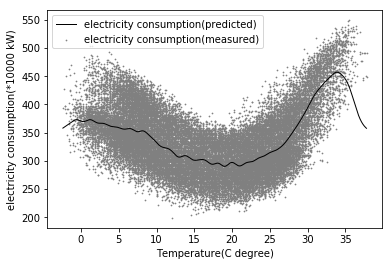

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 交差検定の準備(データ生成)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    takamatsu_wthr, takamatsu_elec, test_size=0.2)

# -- SVR --
model = sklearn.svm.SVR()
y_train = y_train.flatten()
y_test = y_test.flatten()

model.fit(x_train, y_train)

# -- 可視化 --
px = np.arange(takamatsu_wthr.min(), takamatsu_wthr.max(), 0.01)[:, np.newaxis]
py = model.predict(px)

# 以下グラフ生成
plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.plot(px, py, color="black", linewidth=1,
         label='electricity consumption(predicted)')

plt.scatter(takamatsu_wthr, takamatsu_elec, s=0.5,
            color="gray", label='electricity consumption(measured)')

plt.legend(loc='upper left')
plt.show()
